In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Data initialization

In [ ]:
# Downloading load profile from the excel file
data = pd.read_excel('/content/data_senchuk.xlsx', sheet_name= 'ЭП')
load_history = data['Нагрузка, кВт']
load_history_np = load_history.to_numpy().reshape(-1, 24)

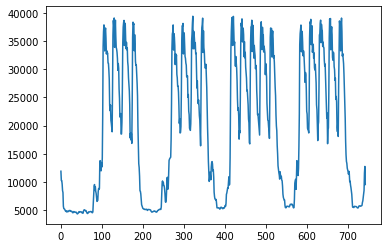

In [ ]:
plt.plot(load_history)

In [ ]:
# Downloading prices array from the excel file
prices_with_components = pd.read_excel('/content/prices.xlsx')
prices_with_components = prices_with_components.drop(axis = 1, index = [0])
prices_total = []
for i in range(0, 31):
  prices_total += [prices_with_components.iloc[i*5].to_numpy()[1:]]
prices_total = np.array(prices_total)

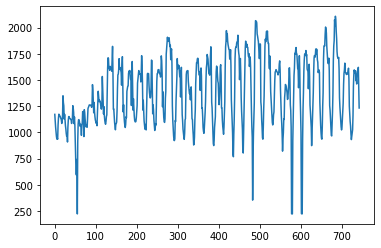

In [ ]:
plt.plot(prices_total.reshape(-1))

In [ ]:
work_days = [6, 7, 8, 12, 13, 14, 15, 18, 19, 20, 21, 22, 25, 26, 27, 28, 29]
peak_hours = [21, 21, 21, 21, 11, 21, 11, 15, 11, 21, 12, 14, 11, 11, 11, 11, 14]
pchpn = [8, 9, 10, 11, 12, 13, 14, 15, 20, 21]

# Illustrative cost calculation

In [ ]:
expenses_energy = np.sum(prices_total * load_history_np) / 1000
expenses_energy

21650812.98455124

In [ ]:
peak_loads = []
for day, hour in zip(work_days, peak_hours):
  peak_loads += [load_history_np[day - 1][hour - 1]]

In [ ]:
expenses_power = np.mean(peak_loads) * 940879.77 / 1000
expenses_power

32306276.247182958

In [ ]:
peak_transmission = []
for day in work_days:
  loads_pchpn = []
  for hour in pchpn:
    loads_pchpn += [load_history_np[day - 1][hour - 1]]
  peak_transmission += [np.max(loads_pchpn)]

In [ ]:
expenses_transmission = np.mean(peak_transmission) * 948820.42 / 1000
expenses_transmission

36655927.96828935

In [ ]:
total_expenses = expenses_energy + expenses_power + expenses_transmission
total_expenses

90613017.20002356

Text(0.5, 1.0, '4th category price by components')

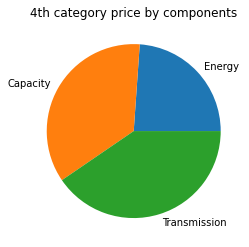

In [ ]:
plt.pie([expenses_energy, expenses_power, expenses_transmission], labels = ['Energy', 'Capacity', 'Transmission'])
plt.title('4th category price by components')

# Data preprocessing

In [ ]:
# Creation of arrays to calculate the mean power consumption in GS peak and planned peak hours.

# An array with 0 for non-peak hour and historical power load for the peak hours
peak_loads = []
# An array with 0 for non-peak hour and 1 for the peak hours
peak_loads_mask = []
count = 0
for i in range(load_history_np.shape[0]):
  # We shift only on working days
  if i+1 in work_days:
    work_day = np.zeros(24)
    work_day_mask = np.zeros(24)
    work_day[peak_hours[count]-1] = load_history_np[i][peak_hours[count]-1]
    work_day_mask[peak_hours[count]-1] = 1
    peak_loads += [work_day]
    peak_loads_mask += [work_day_mask]
    count += 1
  else:
    peak_loads += [np.zeros(24)]
    peak_loads_mask += [np.zeros(24)]
peak_loads = np.array(peak_loads)
peak_loads_mask = np.array(peak_loads_mask)

# An array wih 0 for non-planned-peak-hour and historical power load for planned peak hour.
pchpn_loads = []
# An array wih 0 for non-planned-peak-hour and 1 for planned peak hour.
pchpn_loads_mask = []
for i in range(load_history_np.shape[0]):
  if i+1 in work_days:
    work_day = np.zeros(24)
    work_day_mask = np.zeros(24)
    work_day[7:15] = load_history_np[i][7:15]
    work_day_mask[7:15] = 1
    work_day[19:21] = load_history_np[i][19:21]
    work_day_mask[19:21] = 1
    pchpn_loads += [work_day]
    pchpn_loads_mask += [work_day_mask]
  else:
    pchpn_loads += [np.zeros(24)]
    pchpn_loads_mask += [np.zeros(24)]
pchpn_loads = np.array(pchpn_loads)
pchpn_loads_mask = np.array(pchpn_loads_mask)

# An array with 1 for the days, when we do not implement shifting (it is needed for the corresponding constraint)
holidays_mask = np.zeros(24*31)
holidays_mask[0:5 * 24] = 1
holidays_mask[8 * 24:11 * 24] = 1
holidays_mask[15 * 24:17 * 24] = 1
holidays_mask[22 * 24:24 * 24] = 1
holidays_mask[29 * 24:31 * 24] = 1

# Optimization

In [ ]:
DR = 1 # MW, The power, decreased during DR event
r = 0.1 # Loss factor
x = cp.Variable(24*31) # Initializing set of variables
v = cp.Variable(24*31)

In [ ]:
# Objective function
def func_month():
  load_corrected = load_history_np.reshape(-1) + x
 
  peak_loads_corrected = cp.multiply((peak_loads.reshape(-1) + x), peak_loads_mask.reshape(-1))
  
  pchpn_loads_corrected = cp.multiply((pchpn_loads.reshape(-1) + x),  pchpn_loads_mask.reshape(-1))

  return cp.sum(cp.multiply(prices_total.reshape(-1) , load_corrected)) / 1000 , cp.sum(peak_loads_corrected) / len(work_days) * 940879.77 / 1000 , cp.sum(cp.max(cp.atoms.affine.reshape.reshape(pchpn_loads_corrected, (31, 24) ), axis = 1)) / len(work_days) * 948820.42 / 1000

In [ ]:
def get_results(mode = 'storage', DR = 1, r = 0.1):
  objective = cp.Minimize(func_month()[0] + func_month()[1] + func_month()[2])
  if mode == 'storage':
    constraints = [cp.abs(x) <=1000,
                   cp.multiply(x , holidays_mask) == 0, 
                   x[14*24+12:14*24+16] == -900 * DR, 
                   x[28*24+10:28*24+14] == -900 * DR, 
                   x >= (-(cp.cumsum(x) - x) * (1 - r)), 
                   x <= ((4000 - (cp.cumsum(x) - x)) / (1 - r))]
  elif mode == 'load':
    constraints = [cp.sum(x) ==0, 
                   cp.abs(x) <=6500, 
                   cp.multiply(x , holidays_mask) == 0]
  prob = cp.Problem(objective, constraints)  
  result = prob.solve()

  # Plotting
  plt.figure(figsize = (35,10))
  plt.plot(load_history_np.reshape(-1))
  plt.plot(load_history_np.reshape(-1)+x.value)
  plt.xlabel('Hour')
  plt.ylabel('kW')
  return load_history_np.reshape(-1)+x.value

In [ ]:
def func_for_plot(a = True):
  if a:
    load_corrected = load_history_np.reshape(-1) + x.value
    peak_loads_corrected = np.multiply((peak_loads.reshape(-1) + x.value), peak_loads_mask.reshape(-1))
    pchpn_loads_corrected = np.multiply((pchpn_loads.reshape(-1) + x.value),  pchpn_loads_mask.reshape(-1))

  else:
    load_corrected = load_history_np.reshape(-1)
    peak_loads_corrected = peak_loads.reshape(-1)
    pchpn_loads_corrected = pchpn_loads.reshape(-1)

  return np.sum(np.multiply(prices_total.reshape(-1) , load_corrected)) / 1000 , np.sum(peak_loads_corrected) / 17 * 940879.77 / 1000 , np.sum(np.max(pchpn_loads_corrected.reshape(31, 24) , axis = 1)) / 17 * 948820.42 / 1000

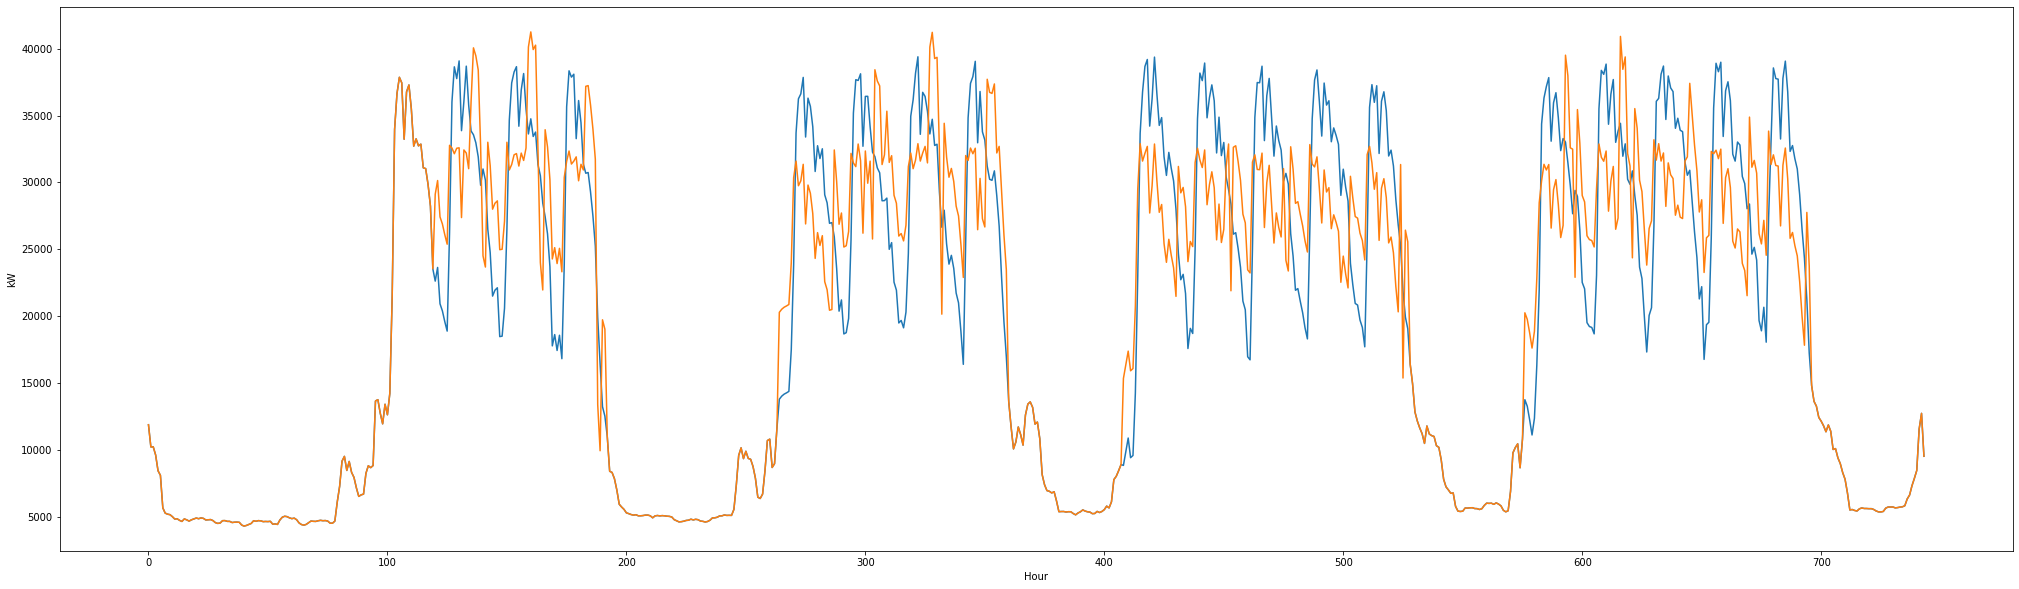

In [ ]:
# Optimization for the shiftable load
optimized_profile = get_results(mode = 'load')

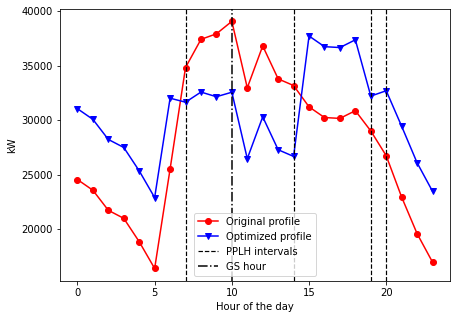

In [ ]:
plt.figure(figsize = (7,5))
plt.plot(load_history_np.reshape(-1)[14*24:15*24], 'ro', ls = '-')
plt.plot(load_history_np.reshape(-1)[14*24:15*24]+x.value[14*24:15*24], 'bv', ls = '-' )
plt.xlabel('Hour of the day')
plt.ylabel('kW')

plt.axvline(7, ls = '--', c = 'k', lw = 1.2)
plt.axvline(10, ls = '-.', c = 'k')
plt.axvline(14, ls = '--', c = 'k' , lw = 1.2)
plt.axvline(19, ls = '--', c = 'k', lw = 1.2)
plt.axvline(20, ls = '--', c = 'k', lw = 1.2)
plt.legend(('Original profile', 'Optimized profile','PPLH intervals', 'GS hour'))
plt.savefig('load_prof')
plt.savefig('corrected_load.svg', format='svg', dpi=10000)

In [ ]:
a = func_for_plot(a = True)
b = func_for_plot(a = False)
print('With correction: Energy:', a[0], 'Power:', a[1], 'Transmission:',a[2], 'Sum:', a[0]+a[1]+a[2])
print('Original: Energy:', b[0], 'Power:', b[1], 'Transmission:',b[2], 'Sum:', b[0]+b[1]+b[2])
print('Savings: Energy:', b[0] - a[0], 'Power:', b[1] - a[1], 'Transmission:', b[2] - a[2], 'Sum:', - a[0] + b[0] - a[1] + b[1] - a[2] + b[2])

With correction: Energy: 20981957.494750895 Power: 26190557.742032595 Transmission: 30905290.546223346 Sum: 78077805.78300683
Original: Energy: 21650812.98455124 Power: 32306276.247182958 Transmission: 36655927.96828934 Sum: 90613017.20002353
Savings: Energy: 668855.4898003452 Power: 6115718.505150363 Transmission: 5750637.422065992 Sum: 12535211.4170167


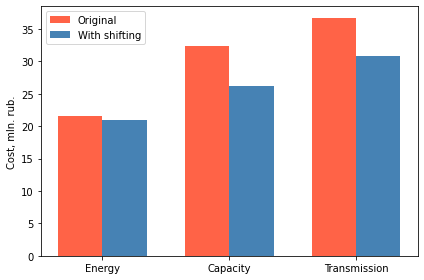

In [ ]:
df = pd.DataFrame( {'Energy': {'With shifting':20.981, 'Original':21.650}, 'Capacity': {'With shifting': 26.190, 'Original': 32.306}, 'Transmission': {'With shifting': 30.905, 'Original': 36.655}} )

labels = ['Energy', 'Capacity', 'Transmission']
original = [21.650, 32.306, 36.655]
with_shifting = [20.981, 26.190, 30.905]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, original, width, label='Original', color = 'tomato')
rects2 = ax.bar(x + width/2, with_shifting, width, label='With shifting', color = 'steelblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Cost, mln. rub.')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.savefig('barchart.svg', format='svg', dpi=10000)
plt.show()

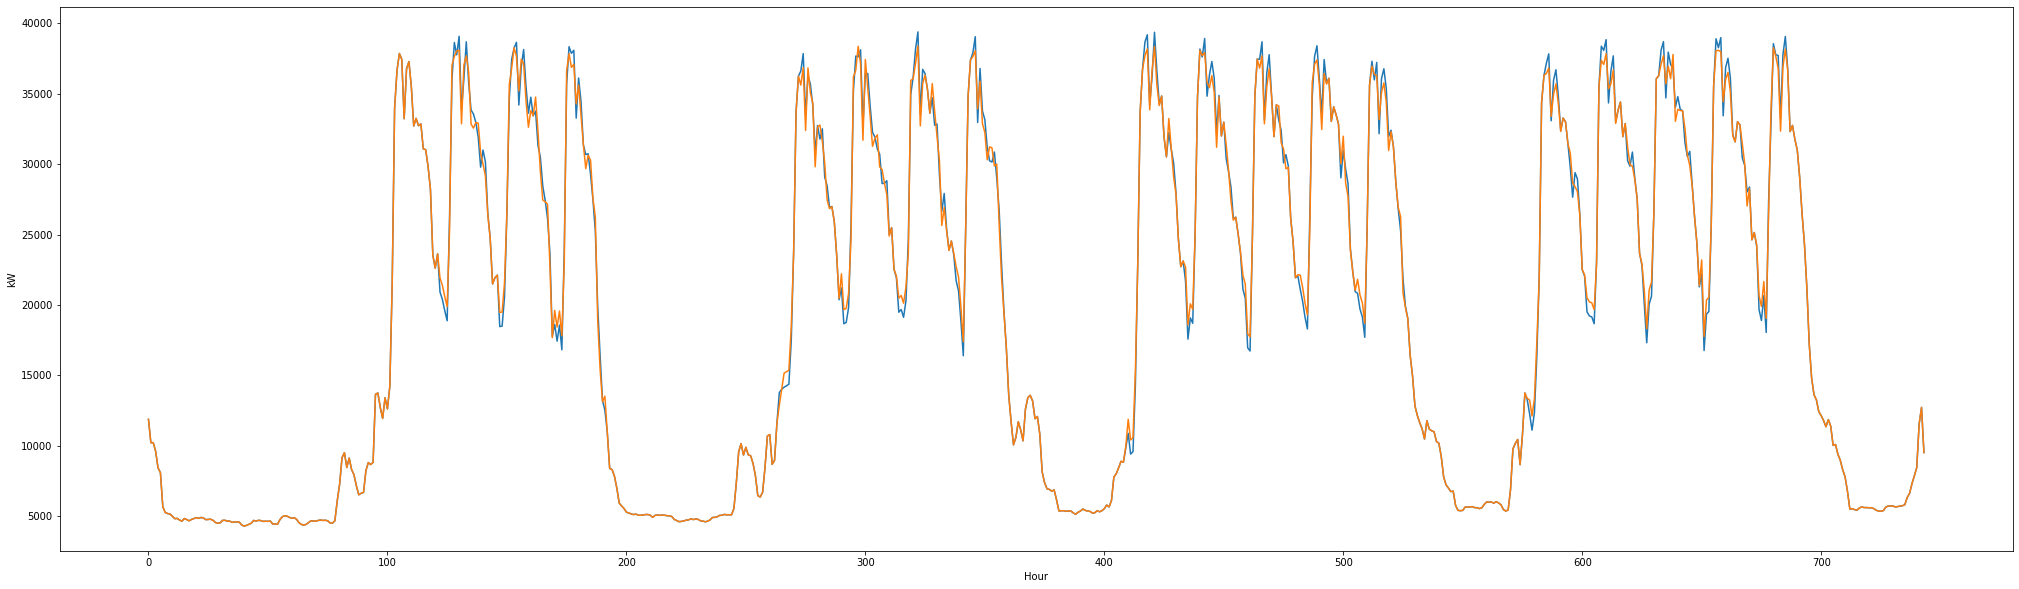

In [ ]:
# Optimization for the energy storage
optimized_profile = get_results(mode = 'storage')

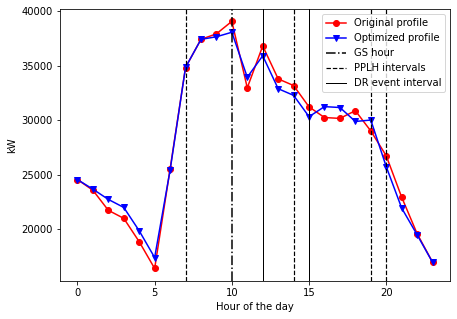

In [ ]:
plt.figure(figsize = (7,5))
plt.plot(load_history_np.reshape(-1)[14*24:15*24], 'ro', ls = '-')
plt.plot(load_history_np.reshape(-1)[14*24:15*24]+x.value[14*24:15*24], 'bv', ls = '-')
plt.xlabel('Hour of the day')
plt.ylabel('kW')

plt.axvline(10, ls = '-.', c = 'k')
plt.axvline(7, ls = '--', c = 'k', lw = 1.2)
plt.axvline(12, ls = '-', c = 'k', lw = 1)

plt.axvline(14, ls = '--', c = 'k', lw = 1.2)
plt.axvline(19, ls = '--', c = 'k', lw = 1.2)
plt.axvline(20, ls = '--', c = 'k', lw = 1.2)
plt.axvline(15, ls = '-', c = 'k', lw = 1)
plt.legend(('Original profile', 'Optimized profile', 'GS hour', 'PPLH intervals', 'DR event interval'))
plt.savefig('corrected_storage.svg', format='svg', dpi=10000)

In [ ]:
a = func_for_plot(a = True)
b = func_for_plot(a = False)
print('With correction: Energy:', a[0], 'Power:', a[1], 'Transmission:',a[2], 'Sum:', a[0]+a[1]+a[2]- DR * 270000)
print('Original: Energy:', b[0], 'Power:', b[1], 'Transmission:',b[2], 'Sum:', b[0]+b[1]+b[2])
print('Savings: Energy:', b[0] - a[0], 'Power:', b[1] - a[1], 'Transmission:', b[2] - a[2], 'Sum:', - a[0] + b[0] - a[1] + b[1] - a[2] + b[2] + DR * 270000)

With correction: Energy: 21589227.961289357 Power: 31370931.06343861 Transmission: 35906372.09624523 Sum: 88596531.1209732
Original: Energy: 21650812.98455124 Power: 32306276.247182958 Transmission: 36655927.96828934 Sum: 90613017.20002353
Savings: Energy: 61585.023261882365 Power: 935345.1837443486 Transmission: 749555.8720441088 Sum: 2016486.0790503398
